In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    print("Hangeul OK in your MAC!!!")
    rc("font", family="Arial Unicode MS")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    print("Hangeul OK in your Windows!!!")
    rc("font", family=font_name)
else:
    print("Unknown system.. sorry~~~")

# 음수일때 오류 나는것 방지
plt.rcParams["axes.unicode_minus"] = False

Hangeul OK in your Windows!!!


## 문제 정의

3개월 전 오송 지하차도 침수 사고 기억 나시나요?  사고 당일인 7월 15일에는 충청권에 호우경보가 내려졌으며 이 때문에 당시 지하차도 인근 제방 둑이 터지면서 도로와 농경지로 강물이 흘러들었고, 이 물이 지하차도에도 유입되어 침수되어 사상자가 발생하였습니다.

금강에서의 홍수 문제는 6년전 청주 물난리 사태때도 있었습니다. 그 때는 제가 군대에서 청주로 대민지원을 갔었습니다… 

다시 본론으로 돌아가서 **하천의 범람**은 시민들의 생계를 위협하는 중대한 문제이기 때문에 당시 저희 팀에서는 이런 문제를 해결하기 위해 하천의 **배수구조물들의 배수능력을 검토**하게 되었습니다.

### 왜 배수시설물들의 과부족값을 예측하려고 하는가?
(과부족값이란 현재의 물을 배수할 수 있는 능력을 넘어선 수치로 음수값이 나올 경우 능력 부족)

- 배수시설물의 배수능력 부족으로 인한 하천 범람을 미리 예측하여 막기 위해
- 기존의 엑셀 프로그램으로 손수 계산하여 과부족값을 구하는 단계를 머신러닝을 통해 간소화하기 위함

---

## 데이터 수집

- 국토정보지리원에서 데이터 크롤링을 통해 하천 인근 지역의 수치지도를 수집함
    - 수집된 수치지도에는 점과 선으로 된 공간데이터가 들어가 있음
- 유출계수 산정을 위해 필요한 지역의 토지피복도 shp파일을 국가공간정보포털에서 수집함
- 배수시설물의 현 규격을 측량회사로부터 수집함

---

## 데이터 전처리

- 하천을 하나로 보아야하기 때문에 CAD상에서 수치지도 결합
- 공공기관에 납품을 하기위해 수치지도를 GRS80 → Bessel 로 좌표계 변환 (QGIS사용)
- 큰 하천으로 물이 직접적으로 들어가지 않는 배수펌프장과 소하천의 유역계를 제외
- 하천의 유역계(물이 흘러가는 길)를 로드뷰를 보며 판단하여 그리기
    - 이 과정을 통해 각 배수시설물마다 유역계를 확인할 수 있음
- 유역계를 QGIS에 폴리곤 데이터로 생성하고, 토지피복도 shp파일과 **clip**을 통해 특정 지역에 해당하는 토지피복도를 얻을 수 있음


- 해당 지역의 토지피복도와 폴리곤 레이어를 병합하고, 아래의 엑셀파일을 토지피복도 코드를 기준으로 결합시킵니다.

- 필드 계산기를 통해 해당 영역의 면적 ($area)을 추가해줌 (**집수면적** 산정을 위해)
- 위에서 얻은 속성값을 csv파일로 Export한 후 엑셀에서 면적*유출계수 / 집수면적 = 유츨계수 계산을 통해 **유출계수** 산정
- 티센망을 활용한 하천의 지배 관측소 지정

- 유역계 폴리곤 데이터와 티센망을 clip하고 필드 계산기 통해 면적 계산함
- 배수시설물마다 가장 큰 티센망 면적을 가진 관측소를 지베관측소로 지정함
- 지배 관측소에 해당하는 6개의 계수를 강우강도식에 대입하여 **강우강도**를 산정함

---

## 데이터분석

- **분류 모델**: 과부족값을 기준으로 하천의 단면이 적절한지 판단하는 **이진 분류 문제**로 접근할 수 있습니다.
    - 특성 : 유출계수, 강우강도, 집수면적, 현단면
    - 라벨 : 과부족값이 양수인지(즉, 단면이 충분한지) 또는 음수인지(즉, 단면이 부족한지)를 나타내는 이진 값
    - 분류 모델: Logistic Regression, Decision Tree, Random Forest, LGBM, XGBoost
- 2개, 4개의 특성들을 각각 넣어보고 뭐가 가장 정확한지 성능확인
- 가장 성능이 잘 나온 인자들이 과부족값에 큰 영향을 미침 따라서 앞으로 중점적으로 보완할 요소를 얻을 수 있음
- 한 하천에 대해서 모델을 학습시킨 것에 대해서 다른 2개의 하천들을 넣어봤을 때 과부족값에 대해서 얼마나 예측할 수 있는지 확인해봄

---

In [33]:
# 금천, 구룡천, 길산천 데이터
df = pd.read_excel("./배수능력검토_모델링.xlsx", header=0, index_col=0)
df.head()

,현단면,유출계수,강우강도,집수면적,과부족
배수시설명,0.79,0.77,50.150366,0.033609,0.62
금천제1배수통관,0.79,0.78,38.588700,0.036453,0.64
금천제2배수통관,3.00,0.74,54.986181,0.127314,2.31
금천제1배수문,1.13,0.76,46.802044,0.042033,0.93
금천제3배수통관,2.25,0.75,51.702577,0.059872,1.94


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 배수시설명 to 길산제72배수통관
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   현단면     335 non-null    float64
 1   유출계수    335 non-null    float64
 2   강우강도    335 non-null    float64
 3   집수면적    335 non-null    float64
 4   과부족     335 non-null    float64
dtypes: float64(5)
memory usage: 15.7+ KB


---

### 데이터 전처리

- 과부족값을 라벨로 놓고 나머지 칼럼은 특성값임
- 과부족이 0 이상일때는 배수시설물을 존치하고 음수일때는 배수시설물 재가설(홍수 위험)
- 따라서 분류 모델로 예측하기 위해 0 이상일 때 1, 음수일 때 0 으로 처리함


In [35]:
# 과부족 column 전처리
df["과부족"] = [1 if s>=0 else 0 for s in df["과부족"]]
df

,현단면,유출계수,강우강도,집수면적,과부족
배수시설명,0.79,0.77,50.150366,0.033609,1
금천제1배수통관,0.79,0.78,38.588700,0.036453,1
금천제2배수통관,3.00,0.74,54.986181,0.127314,1
금천제1배수문,1.13,0.76,46.802044,0.042033,1
금천제3배수통관,2.25,0.75,51.702577,0.059872,1
...,...,...,...,...,...
길산제68배수통관,0.50,0.78,33.777446,0.065009,1
길산제69배수통관,0.50,0.78,37.932066,0.019197,1
길산제70배수통관,0.50,0.78,50.604614,0.067655,1
길산제71배수통관,0.79,0.72,48.983890,0.096836,1


In [36]:
# 특성 객체만 numpy 배열로 변환
np_df = df.iloc[:, :4].to_numpy()
np_df

array([[7.90000000e-01, 7.70000000e-01, 5.01503662e+01, 3.36094060e-02],
       [7.90000000e-01, 7.80000000e-01, 3.85886997e+01, 3.64531030e-02],
       [3.00000000e+00, 7.40000000e-01, 5.49861811e+01, 1.27314104e-01],
       ...,
       [5.00000000e-01, 7.80000000e-01, 5.06046137e+01, 6.76546220e-02],
       [7.90000000e-01, 7.20000000e-01, 4.89838905e+01, 9.68359490e-02],
       [2.00000000e-01, 6.80000000e-01, 2.73567986e+01, 4.19195690e-02]])

- 특성간의 척도 차이가 커서 이를 제거하기 위해 정규화시킴

In [37]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss_data = ss.fit_transform(np_df)
ss_data

array([[-0.30628504,  0.35181828,  1.61509341, -0.42089496],
       [-0.30628504,  0.58613066,  0.4339729 , -0.41694847],
       [ 0.06237342, -0.35111884,  2.10911217, -0.29085143],
       ...,
       [-0.35466104,  0.58613066,  1.66149858, -0.37364695],
       [-0.30628504, -0.81974359,  1.4959282 , -0.33314906],
       [-0.40470517, -1.75699309, -0.71345932, -0.4093621 ]])

---

###  현단면, 유출계수, 강우강도, 집수면적 4개의 feature를 모두 사용 

- 과적합되는 것을 막기 위해 train, test 데이터로 나누어서 모델을 학습

In [38]:
from sklearn.model_selection import train_test_split

X = ss_data
y = df["과부족"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [39]:
# 클래스별 개수 확인
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([11, 56], dtype=int64))

In [40]:
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([ 31, 237], dtype=int64))

### DecisionTree 사용

- 클래스 불균형이 있는 데이터셋에서 0(홍수 위험 시설물)을 잡아내는 것이 중요함
- 따라서 재현율(Recall)이나 F1 점수(F1 Score)가 유용한 지표
- Stratified K-fold Cross-validation 사용하여 교차검증할 것임
- 분류 문제에서, 특히 불균형 데이터 세트에서 유용하기 때문에 쓰는것

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

skfold = StratifiedKFold(n_splits=5)
dt = DecisionTreeClassifier(max_depth=6, random_state=13)

# 교차 검증을 위한 설정
scoring = ['recall', 'f1']

# `cross_validate` 함수를 사용하여 교차 검증 수행
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=skfold, return_train_score=False)

dt_mean_recall = np.mean(dt_scores['test_recall'])
dt_mean_f1 = np.mean(dt_scores['test_f1'])

print(f"Average test Recall: {dt_mean_recall:.4f}")
print(f"Average test F1 Score: {dt_mean_f1:.4f}")


dt.fit(X_train, y_train)

Average test Recall: 0.9524
Average test F1 Score: 0.9409


DecisionTreeClassifier(max_depth=6, random_state=13)

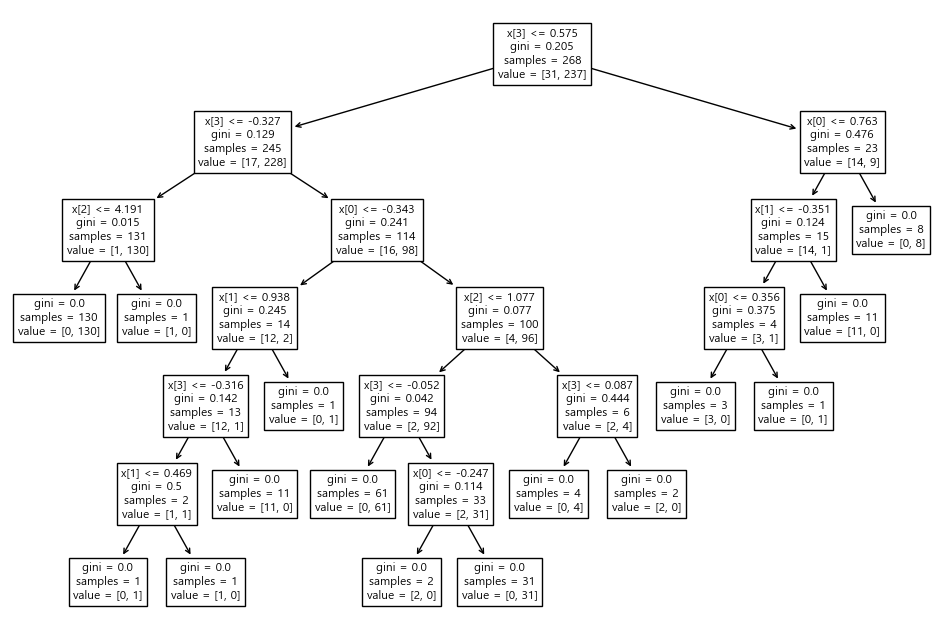

In [42]:
# train 데이터의 결정나무 모델
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(dt);

In [43]:
dt.feature_importances_

array([0.56079796, 0.05378757, 0.05623317, 0.3291813 ])

- 특성의 중요도는 각 노드에서의 특성 선택으로 인한 불순도 감소의 총 합계를 기반으로 계산
- 불순도 감소가 클수록 분류가 잘 되었다는 뜻이므로 현단면이 과부족값을 분류하는데 가장 중요한 값임

=> 하천의 범람은 그 물을 담을 그릇의 용적이 부족하여 발생되기 때문에 충분히 설득력있는 수치임

### Logistic Regression - 분류

In [44]:
from sklearn.linear_model import LogisticRegression

# 작은 데이터셋에 liblinear 최적화 방법이 적절함
# ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']  성능이 비슷함
lr = LogisticRegression(solver="liblinear", random_state=13)

# `cross_validate` 함수를 사용하여 교차 검증 수행
lr_scores = cross_validate(lr, X, y, scoring=scoring, cv=skfold, return_train_score=False)

lr_mean_recall = np.mean(lr_scores['test_recall'])
lr_mean_f1 = np.mean(lr_scores['test_f1'])


print(f"Average test Recall: {lr_mean_recall:.4f}")
print(f"Average test F1 Score: {lr_mean_f1:.4f}")

lr.fit(X_train, y_train)

Average test Recall: 0.9797
Average test F1 Score: 0.9409


LogisticRegression(random_state=13, solver='liblinear')

### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)


# `cross_validate` 함수를 사용하여 교차 검증 수행
rf_scores = cross_validate(rf_clf, X, y, scoring=scoring, cv=skfold, return_train_score=False)

rf_mean_recall = np.mean(rf_scores['test_recall'])
rf_mean_f1 = np.mean(rf_scores['test_f1'])


print(f"Average test Recall: {rf_mean_recall:.4f}")
print(f"Average test F1 Score: {rf_mean_f1:.4f}")

rf_clf.fit(X_train, y_train)

Average test Recall: 0.9728
Average test F1 Score: 0.9423


RandomForestClassifier(n_jobs=-1, random_state=13)

### LightGBM

In [46]:
from lightgbm import LGBMClassifier


# 가장 성능이 좋을때의 파라미터
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.9, max_depth=3)

# `cross_validate` 함수를 사용하여 교차 검증 수행
lgbm_scores = cross_validate(lgbm, X, y, scoring=scoring, cv=skfold, return_train_score=False)

lgbm_mean_recall = np.mean(lgbm_scores['test_recall'])
lgbm_mean_f1 = np.mean(lgbm_scores['test_f1'])





lgbm.fit(X_train, y_train)

print(f"Average test Recall: {lgbm_mean_recall:.4f}")
print(f"Average test F1 Score: {lgbm_mean_f1:.4f}")


[LightGBM] [Info] Number of positive: 234, number of negative: 34
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.873134 -> initscore=1.928961
[LightGBM] [Info] Start training from score 1.928961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

### XGBoost

In [47]:
from xgboost import XGBClassifier

# 가장 성능이 좋을 때의 파라미터
xgb = XGBClassifier(n_estimators=70, learning_rate=0.5, max_depth=2)

# `cross_validate` 함수를 사용하여 교차 검증 수행
xgb_scores = cross_validate(xgb, X, y, scoring=scoring, cv=skfold, return_train_score=False)

xgb_mean_recall = np.mean(xgb_scores['test_recall'])
xgb_mean_f1 = np.mean(xgb_scores['test_f1'])


print(f"Average test Recall: {xgb_mean_recall:.4f}")
print(f"Average test F1 Score: {xgb_mean_f1:.4f}")

xgb.fit(X_train, y_train)



Average test Recall: 0.9762
Average test F1 Score: 0.9566


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

 이제 모든 분류기를 한 번에 성능을 비교해보자

In [48]:
# 테스트 데이터만 비교

print("Decision Tree")
print(f"Average test Recall: {dt_mean_recall:.4f}")
print(f"Average test F1 Score: {dt_mean_f1:.4f}")
print("~"*30)
print("Logistic Regression")
print(f"Average test Recall: {lr_mean_recall:.4f}")
print(f"Average test F1 Score: {lr_mean_f1:.4f}")
print("~"*30)
print("Random Forest")
print(f"Average test Recall: {rf_mean_recall:.4f}")
print(f"Average test F1 Score: {rf_mean_f1:.4f}")
print("~"*30)
print("LightGBM")
print(f"Average test Recall: {lgbm_mean_recall:.4f}")
print(f"Average test F1 Score: {lgbm_mean_f1:.4f}")
print("~"*30)
print("XGBoost")
print(f"Average test Recall: {xgb_mean_recall:.4f}")
print(f"Average test F1 Score: {xgb_mean_f1:.4f}")



Decision Tree
Average test Recall: 0.9524
Average test F1 Score: 0.9409
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic Regression
Average test Recall: 0.9797
Average test F1 Score: 0.9409
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Random Forest
Average test Recall: 0.9728
Average test F1 Score: 0.9423
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LightGBM
Average test Recall: 0.9693
Average test F1 Score: 0.9530
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
XGBoost
Average test Recall: 0.9762
Average test F1 Score: 0.9566


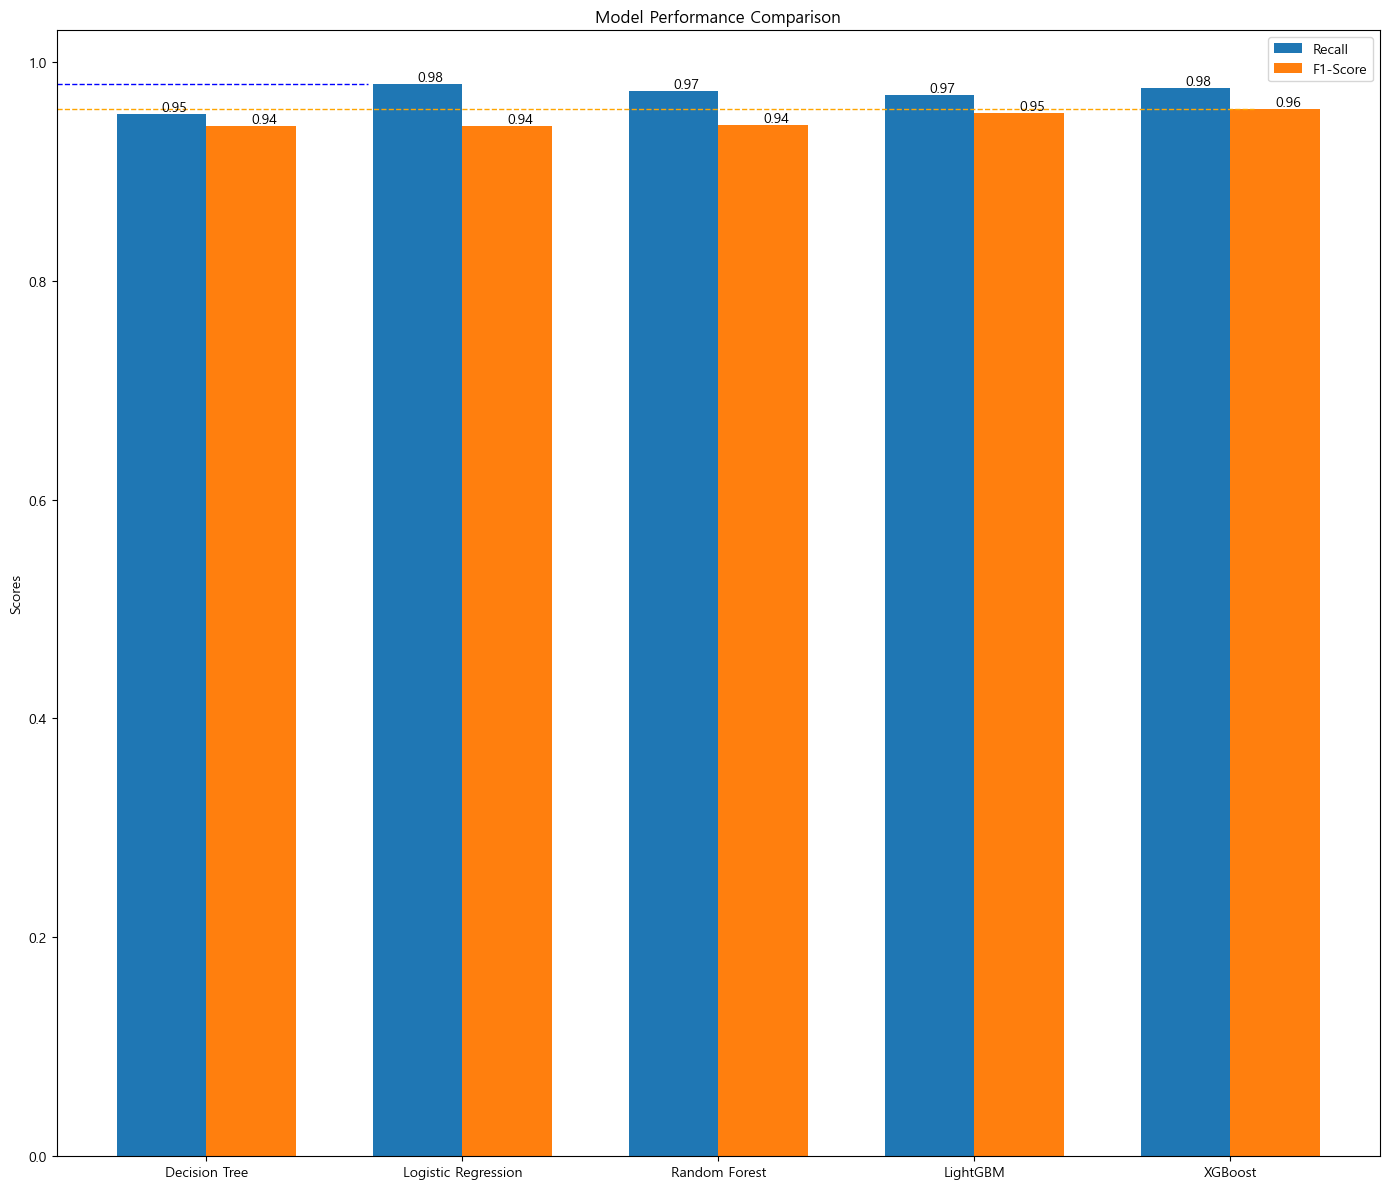

In [49]:
def scoreGraph():
    plt.figure(figsize=(14, 12))

    # Performance metrics for each model
    recall_scores = [dt_mean_recall, lr_mean_recall, rf_mean_recall, lgbm_mean_recall, xgb_mean_recall]
    f1_scores = [dt_mean_f1, lr_mean_f1, rf_mean_f1, lgbm_mean_f1, xgb_mean_f1]

    # Model names
    models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

    # Bar graph count and position
    n_models = len(models)
    index = np.arange(n_models)
    bar_width = 0.35

    # Recall bar graph
    recall_bars = plt.bar(index, recall_scores, bar_width, label='Recall')

    # F1-Score bar graph
    f1_bars = plt.bar(index + bar_width, f1_scores, bar_width, label='F1-Score')

    # Annotate bars with their values
    for bar in recall_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va='bottom' to align the text under the top edge
    
    for bar in f1_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

    # Draw a dashed line at the maximum score for Recall and F1-Score
    max_recall = max(recall_scores)
    max_f1 = max(f1_scores)
    max_recall_index = recall_scores.index(max_recall)
    max_f1_index = f1_scores.index(max_f1)

    sorted_recall_indices = np.argsort(-np.array(recall_scores))
    top_recall_scores = sorted(recall_scores, reverse=True)[:2]
    
    for i, score in enumerate(top_recall_scores):
        if recall_scores.count(score) > 1:  # Check if there is a tie
            plt.axhline(y=score, color='blue', linestyle='dashed', linewidth=1, xmax=(sorted_recall_indices[i] + bar_width/2)/n_models)

    plt.axhline(y=max_recall, color='blue', linestyle='dashed', linewidth=1, xmax=(index[max_recall_index] + bar_width/2)/n_models)
    plt.axhline(y=max_f1, color='orange', linestyle='dashed', linewidth=1, xmax=(index[max_f1_index] + 1.5*bar_width)/n_models)

    # Model names on x-axis
    plt.xticks(index + bar_width / 2, models)

    # Legend
    plt.legend(loc='upper right')

    # Graph title and axis labels
    plt.title('Model Performance Comparison')
    plt.ylabel('Scores')

    # Show graph
    plt.tight_layout()
    plt.show()

# Call the function
scoreGraph()


- 특성 4개일 경우 모든 성능에서 XGBoost 가장 높은 수치를 나타내고 있음

#### 오송 지하차도 침수 사건의 원인이 된 둑 인근의 배수시설물이 얼마나 홍수에 취약했는지 알아보자

In [50]:
# 현단면 유출계수 강우강도 집수면적
osong = np.array([[12, 0.75, 32.5060289325294, 5.798637425]])

# LightGBM을 이용한 예측
print(f"홍수 위험 확률 : {round(xgb.predict_proba(osong)[0, 1] * 100, 2)}%")

홍수 위험 확률 : 57.58%



- 과부족 확률이 58% 정도 절반을 넘긴 수치 => 그만큼 홍수 위험 지역이라는 뜻
- 추가적으로 인근 교량 공사 위해 수해 예방 방어막을 제거하고 임시 둑을 쌓아놓은 것이 무너져 버림
- 미리 예방할 수 있었던 인재가 아니었을까..?

In [51]:
X_test.shape

(67, 4)

In [52]:
pred_test = xgb.predict(X_test)
wrong = X_test[y_test!=pred_test]
wrong.shape

(6, 4)

---

### 성능을 더 높여보자 그러기 위해선 특성들 상관관계 확인

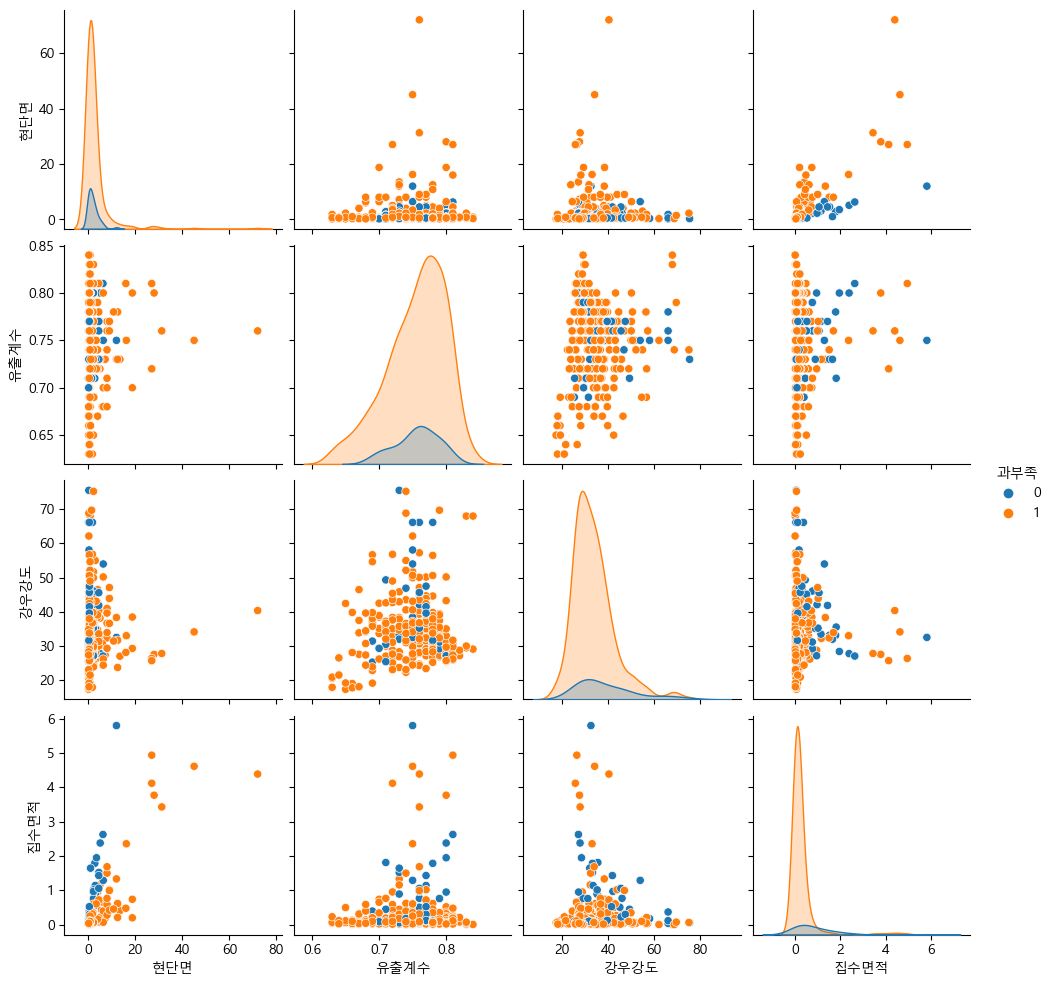

In [53]:
sns.pairplot(data=df, hue="과부족");

- 0과 1로 잘 분류될때의 특성값들은 현단면과 집수면적
- 이 두개의 특성으로 분류 모델을 학습시켜보자

In [54]:
# 집수면적과 현단면 특성값으로 만들기
np_df = df.iloc[:, [0, 3]].to_numpy()
ss_data = ss.fit_transform(np_df)
X = ss_data
y = df["과부족"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [55]:
skfold = StratifiedKFold(n_splits=5)
dt = DecisionTreeClassifier(max_depth=5, random_state=13)

# 교차 검증을 위한 설정
scoring = ['recall', 'f1']

# `cross_validate` 함수를 사용하여 교차 검증 수행
dt_scores = cross_validate(dt, X, y, scoring=scoring, cv=skfold, return_train_score=False)

dt_mean_recall = np.mean(dt_scores['test_recall'])
dt_mean_f1 = np.mean(dt_scores['test_f1'])

print(f"Average test Recall: {dt_mean_recall:.4f}")
print(f"Average test F1 Score: {dt_mean_f1:.4f}")

dt.fit(X_train, y_train)

Average test Recall: 0.9763
Average test F1 Score: 0.9568


DecisionTreeClassifier(max_depth=5, random_state=13)

In [56]:
lr = LogisticRegression(solver="liblinear", random_state=13)

# `cross_validate` 함수를 사용하여 교차 검증 수행
lr_scores = cross_validate(lr, X, y, scoring=scoring, cv=skfold, return_train_score=False)

lr_mean_recall = np.mean(lr_scores['test_recall'])
lr_mean_f1 = np.mean(lr_scores['test_f1'])

print(f"Average test Recall: {lr_mean_recall:.4f}")
print(f"Average test F1 Score: {lr_mean_f1:.4f}")



lr.fit(X_train, y_train)

Average test Recall: 0.9763
Average test F1 Score: 0.9374


LogisticRegression(random_state=13, solver='liblinear')

In [57]:
rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)

# `cross_validate` 함수를 사용하여 교차 검증 수행
rf_scores = cross_validate(rf_clf, X, y, scoring=scoring, cv=skfold, return_train_score=False)

rf_mean_recall = np.mean(rf_scores['test_recall'])
rf_mean_f1 = np.mean(rf_scores['test_f1'])

print(f"Average test Recall: {rf_mean_recall:.4f}")
print(f"Average test F1 Score: {rf_mean_f1:.4f}")


rf_clf.fit(X_train, y_train)

Average test Recall: 0.9627
Average test F1 Score: 0.9433


RandomForestClassifier(n_jobs=-1, random_state=13)

In [58]:
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=2)

# `cross_validate` 함수를 사용하여 교차 검증 수행
lgbm_scores = cross_validate(lgbm, X, y, scoring=scoring, cv=skfold, return_train_score=False)

lgbm_mean_recall = np.mean(lgbm_scores['test_recall'])
lgbm_mean_f1 = np.mean(lgbm_scores['test_f1'])




lgbm.fit(X_train, y_train)


print(f"Average test Recall: {lgbm_mean_recall:.4f}")
print(f"Average test F1 Score: {lgbm_mean_f1:.4f}")

[LightGBM] [Info] Number of positive: 234, number of negative: 34
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.873134 -> initscore=1.928961
[LightGBM] [Info] Start training from score 1.928961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [59]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)


# `cross_validate` 함수를 사용하여 교차 검증 수행
xgb_scores = cross_validate(xgb, X, y, scoring=scoring, cv=skfold, return_train_score=False)

xgb_mean_recall = np.mean(xgb_scores['test_recall'])
xgb_mean_f1 = np.mean(xgb_scores['test_f1'])

print(f"Average test Recall: {xgb_mean_recall:.4f}")
print(f"Average test F1 Score: {xgb_mean_f1:.4f}")



xgb.fit(X_train, y_train)

Average test Recall: 0.9831
Average test F1 Score: 0.9602


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
# 테스트 데이터만 비교

print("Decision Tree")
print(f"Average test Recall: {dt_mean_recall:.4f}")
print(f"Average test F1 Score: {dt_mean_f1:.4f}")
print("~"*30)
print("Logistic Regression")
print(f"Average test Recall: {lr_mean_recall:.4f}")
print(f"Average test F1 Score: {lr_mean_f1:.4f}")
print("~"*30)
print("Random Forest")
print(f"Average test Recall: {rf_mean_recall:.4f}")
print(f"Average test F1 Score: {rf_mean_f1:.4f}")
print("~"*30)
print("LightGBM")
print(f"Average test Recall: {lgbm_mean_recall:.4f}")
print(f"Average test F1 Score: {lgbm_mean_f1:.4f}")
print("~"*30)
print("XGBoost")
print(f"Average test Recall: {xgb_mean_recall:.4f}")
print(f"Average test F1 Score: {xgb_mean_f1:.4f}")



Decision Tree
Average test Recall: 0.9763
Average test F1 Score: 0.9568
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Logistic Regression
Average test Recall: 0.9763
Average test F1 Score: 0.9374
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Random Forest
Average test Recall: 0.9627
Average test F1 Score: 0.9433
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LightGBM
Average test Recall: 0.9729
Average test F1 Score: 0.9580
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
XGBoost
Average test Recall: 0.9831
Average test F1 Score: 0.9602


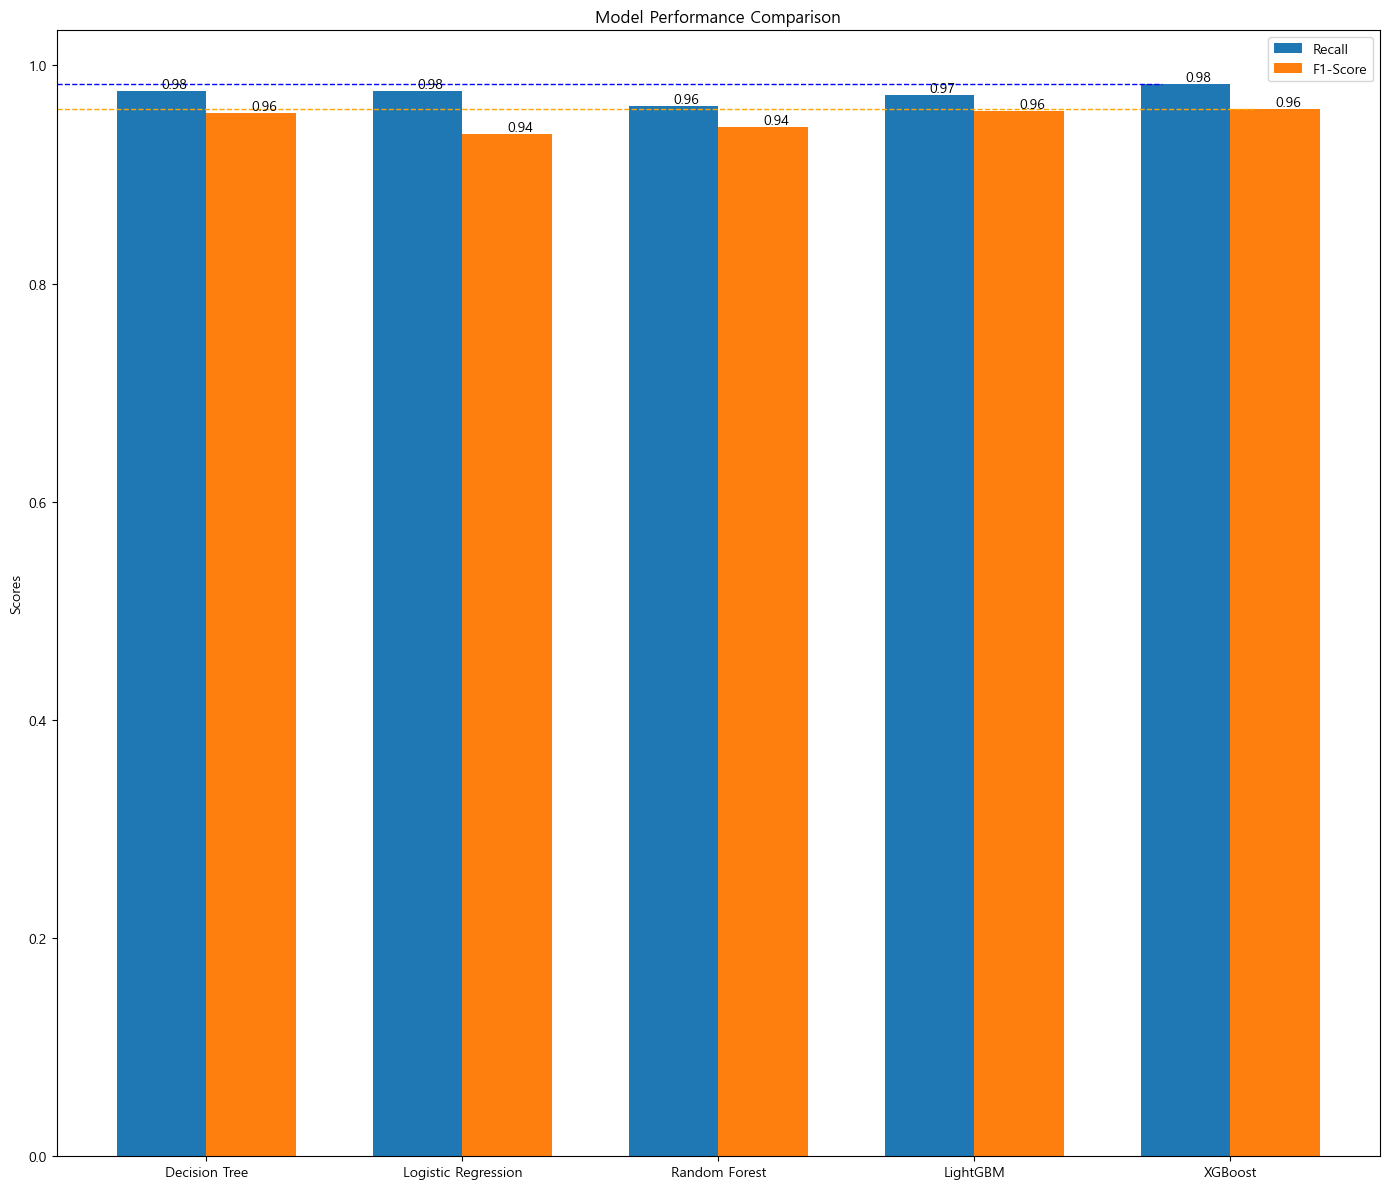

In [61]:
def score2Graph():
    plt.figure(figsize=(14, 12))

    # Performance metrics for each model
    recall_scores = [dt_mean_recall, lr_mean_recall, rf_mean_recall, lgbm_mean_recall, xgb_mean_recall]
    f1_scores = [dt_mean_f1, lr_mean_f1, rf_mean_f1, lgbm_mean_f1, xgb_mean_f1]

    # Model names
    models = ['Decision Tree', 'Logistic Regression', 'Random Forest', 'LightGBM', 'XGBoost']

    # Bar graph count and position
    n_models = len(models)
    index = np.arange(n_models)
    bar_width = 0.35

    # Recall bar graph
    recall_bars = plt.bar(index, recall_scores, bar_width, label='Recall')

    # F1-Score bar graph
    f1_bars = plt.bar(index + bar_width, f1_scores, bar_width, label='F1-Score')

    # Annotate bars with their values
    for bar in recall_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va='bottom' to align the text under the top edge
    
    for bar in f1_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

    # Draw a dashed line at the maximum score for Recall and F1-Score
    max_recall = max(recall_scores)
    max_f1 = max(f1_scores)
    max_recall_index = recall_scores.index(max_recall)
    max_f1_index = f1_scores.index(max_f1)

    sorted_recall_indices = np.argsort(-np.array(recall_scores))
    top_recall_scores = sorted(recall_scores, reverse=True)[:2]
    
    for i, score in enumerate(top_recall_scores):
        if recall_scores.count(score) > 1:  # Check if there is a tie
            plt.axhline(y=score, color='blue', linestyle='dashed', linewidth=1, xmax=(sorted_recall_indices[i] + bar_width/2)/n_models)

    plt.axhline(y=max_recall, color='blue', linestyle='dashed', linewidth=1, xmax=(index[max_recall_index] + bar_width/2)/n_models)
    plt.axhline(y=max_f1, color='orange', linestyle='dashed', linewidth=1, xmax=(index[max_f1_index] + 1.5*bar_width)/n_models)

    # Model names on x-axis
    plt.xticks(index + bar_width / 2, models)

    # Legend
    plt.legend(loc='upper right')

    # Graph title and axis labels
    plt.title('Model Performance Comparison')
    plt.ylabel('Scores')

    # Show graph
    plt.tight_layout()
    plt.show()

# Call the function
score2Graph()


- XGBoost

---

#### 특성 2개일 때 홍수 위험 확률


In [62]:
# 현단면 / 집수면적
osong = np.array([[12, 5.798637425]])

# LightGBM을 이용한 예측
print(f"홍수 위험 확률 : {round(xgb.predict_proba(osong)[0, 0] * 100, 2)}%")

홍수 위험 확률 : 10.54%


- 오히려 성능이 떨어졌네...? 4개의 특성이 더 맞는것 같다
- 줄어든 특성으로 인한 정보의 손실이 발생하여 모델이 중요한 패턴이나 관계를 포착하는 데 필요한 중요한 정보를 놓치게 되었을 수도 있을것 같다.
- 이를 토대로 유출계수와 강우강도 또한 과부족값을 예측하는데 있어서 중요한 요소라고 판단됨